<a href="https://colab.research.google.com/github/CJP123/fastai2colab/blob/master/MNIST_rotate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self-Supervision with FastAI
> A tutorial of rotation-based self-supervision using FastAI2 & PyTorch!

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/self-sup-rotation.png

# Introduction

This notebook is an introduction to self-supervised learning. In short, self-supervised learning has 2 components:

1. Pretrain on a pretext task, where the labels can come from the data itself!
2. Transfer the features, and train on the actual classification labels!

>"What if we can get labels for free for unlabelled data and train unsupervised dataset in a supervised manner? We can achieve this by framing a supervised learning task in a special form to predict only a subset of information using the rest. In this way, all the information needed, both inputs and labels, has been provided. This is known as self-supervised learning." - Lilian Weng

Using FastAI2, we'll use rotation as a pretext task for learning representations/features of our data. 

Here are some great overviews of self-supervised learning that I've come across:

- [Lilian Weng - Self-Supervised Representation Learning](https://lilianweng.github.io/lil-log/2019/11/10/self-supervised-learning)

- [Jeremy Howard - Self-supervised learning and computer vision](https://www.fast.ai/2020/01/13/self_supervised/)

# Experiment Layout

In this notebook, we will be using the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database).

Also check out [ImageWang](https://github.com/fastai/imagenette#image%E7%BD%91) from FastAI themselves! It's a dataset designed for self-supervision tasks!

1. Train a model on a rotation prediction task.
  - We will use *all* the training data for rotation prediction.
  - Input: A rotated image.
  - Target/Label: Classify the amount of degrees rotated.
  - Our model should learn useful features that can transfer well for a classification task.
  - (The model should learn what digits look like in order to be able to successfully predict the amount of rotation).

2. Transfer our rotation pretraining features to solve the classification task with *much fewer* labels, < 1% of the original data.
  - Input: A normal image.
  - Target/Label: The images' *original* categorical label.
  - Classification accuracy should be decent, even with only using < 1% of the original data.

3. Train a classifier from scratch on the same amount of data used in experiment 2.
  - Input: A normal image.
  - Target/Label: The images' *original* categorical label.
  - Classification accuracy should be low (lack of transfer learning & too few labeled data!)
  - Model may overfit.  

# FastAI Vision Model Creation Methods

In [1]:
# Setup Fast AI V2
!pip install git+https://github.com/fastai/fastai2 
!pip install git+https://github.com/fastai/fastcore

  Cloning https://github.com/fastai/fastai2 to /tmp/pip-req-build-vlnd8eut
  Running command git clone -q https://github.com/fastai/fastai2 /tmp/pip-req-build-vlnd8eut
  Created wheel for fastai2: filename=fastai2-0.0.14-cp36-none-any.whl size=182847 sha256=8948c95cb0aa895eeccfa3411022899a80aac905586d620b4e552b6fb2612cb7
  Stored in directory: /tmp/pip-ephem-wheel-cache-a8qslifu/wheels/a1/59/9a/50335b36924b827e29d5f40b41fc3a008cc1f30dd80e560dfd
Successfully built fastai2
  Cloning https://github.com/fastai/fastcore to /tmp/pip-req-build-uhp8foae
  Running command git clone -q https://github.com/fastai/fastcore /tmp/pip-req-build-uhp8foae
  Created wheel for fastcore: filename=fastcore-0.1.16-cp36-none-any.whl size=27850 sha256=576c94928313fa50ba5c99045a29ceb3222942cb531bac3c9da5832e02b09357
  Stored in directory: /tmp/pip-ephem-wheel-cache-rmmipkm3/wheels/8a/2a/23/bc50c8f5e28776b44ac837a01fcfa675724565d4813d8e51c7
Successfully built fastcore
  Found existing installation: fastcore 0.1.

In [0]:
from fastai2.vision.all import *

> Important: Pay attention! It's important. We will be using a small ConvNet to test our self-supervised learning method. The architecture is defined below in `simple_arch`.

*   List item
*   List item



Note that `simple_arch` takes in one argument, `pretrained`. This is to allow FastAI to pass `pretrained=True` or `pretrained=False` when creating the model body! Below are some use cases of when we would want `pretrained=True` or `pretrained=False`.

1. `pretrained=False` = For training a new model on our rotation prediction task.
2. `pretrained=True` = For transferring the learnt features from our rotation task pretraining to solve a classification task.
3. `pretrained=False` = For training a new model from scratch on the main classification task (no transfer learning).

> The follow below code snippets are examples of how FastAI creates CNNs. Every model will have a *body* and a *head*

In [0]:
#collapse-show
# Note that FastAI automatically determines nf for the head!
model = create_cnn_model(arch=resnet18, pretrained=False, n_out=8, lin_ftrs=[])

# PyTorch Rotation/Classification Self-Supervised Dataset

In [18]:
path = untar_data(URLs.MNIST_SAMPLE)

In [0]:
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=RandomSplitter(seed=42),
                  get_y=parent_label)

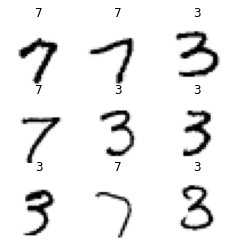

In [53]:
dls = mnist.dataloaders(path)
dls.show_batch(max_n=9, figsize=(4,4))

In [0]:
class MNISTImage(Tuple):
    def show(self, ctx=None, **kwargs): 
        img1,angle = self
        if not isinstance(img1, Tensor):
            t1= tensor(img1)
            t1 = t1.permute(2,0,1)
        else: t1 = img1
        return show_image(torch.cat([t1], dim=2), title=angle, ctx=ctx)

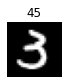

In [58]:
img = PILImage.create(files[1])
s = MNISTImage(img, 45)
s.show();

In [0]:
class MNISTTransform(Transform):
    def __init__(self, files, splits, rotate):
        self.labels = files.map(parent_label).unique()
        self.rotate = rotate
        
    def encodes(self, f):
        img = PILImage.create(f)
        target = parent_label(f)
        if self.rotate:
          angle = random.randint(0,6)*45
          img = img.rotate(angle)
          target = angle
        return MNISTImage(np.array(img), target)

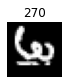

In [111]:
splits = RandomSplitter()(files)
tfm = MNISTTransform(files, splits, rotate=True)
tfm(files[0]).show()

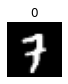

In [112]:
tls = TfmdLists(files, tfm, splits=splits)
show_at(tls.valid, 10);

In [113]:
tls

TfmdLists: [Path('/root/.fastai/data/mnist_sample/valid/3/9750.png'), Path('/root/.fastai/data/mnist_sample/valid/3/8910.png'), Path('/root/.fastai/data/mnist_sample/valid/3/2075.png'), Path('/root/.fastai/data/mnist_sample/valid/3/6739.png'), Path('/root/.fastai/data/mnist_sample/valid/3/782.png'), Path('/root/.fastai/data/mnist_sample/valid/3/5935.png'), Path('/root/.fastai/data/mnist_sample/valid/3/2618.png'), Path('/root/.fastai/data/mnist_sample/valid/3/4841.png'), Path('/root/.fastai/data/mnist_sample/valid/3/8581.png'), Path('/root/.fastai/data/mnist_sample/valid/3/8970.png'), Path('/root/.fastai/data/mnist_sample/valid/3/6636.png'), Path('/root/.fastai/data/mnist_sample/valid/3/699.png'), Path('/root/.fastai/data/mnist_sample/valid/3/9332.png'), Path('/root/.fastai/data/mnist_sample/valid/3/7252.png'), Path('/root/.fastai/data/mnist_sample/valid/3/1463.png'), Path('/root/.fastai/data/mnist_sample/valid/3/8050.png'), Path('/root/.fastai/data/mnist_sample/valid/3/1150.png'), Path

In [114]:
dls = tls.dataloaders(after_item=[ToTensor], after_batch=[IntToFloatTensor, Normalize])

RuntimeError: ignored

In [0]:
# --- Functions to convert between Torch Tensors and PIL Images ---
import torchvision
tensorToImage = torchvision.transforms.ToPILImage()
imageToTensor = torchvision.transforms.ToTensor()

In [0]:
# Download MNIST dataset from PyTorch if not downloaded already!
torchvision.datasets.MNIST('data/', download='True')

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...



Done!


Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train

Below we define a dataset, here's the docstring:

A Dataset for Rotation-based Self-Supervision! Images are rotated clockwise.
- `file` - MNIST processed .pt file.
- `pct` - percent of data to use
- `classification` - False=Use rotation labels. True=Use original classification labels.

In [0]:
#collapse-hide
class Custom_Dataset_MNIST():
    '''
    A Dataset for Rotation-based Self-Supervision! Images are rotated clockwise.
    - file - MNIST processed .pt file.
    - pct - percent of data to use
    - classification - False=Use rotation labels. True=Use original classification labels.
    '''
    
    def __init__(self, file, pct, classification):
        
        data = torch.load(file)
        self.imgs = data[0]
        self.labels = data[1]
        self.pct = pct
        self.classification = classification
                    
        slice_idx = int(len(self.imgs)*self.pct)
        self.imgs = self.imgs[:slice_idx]
                    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = self.imgs[idx].unsqueeze(0)
        img = tensorToImage(img)
        img = img.resize((32, 32), resample=1)
        img = imageToTensor(img)
        
        if (not self.classification):
            # 4 classes for rotation
            degrees = [0, 45, 90, 135, 180, 225, 270, 315]
            rand_choice = random.randint(0, len(degrees)-1)
            
            img = tensorToImage(img)
            img = img.rotate(degrees[rand_choice])
            img = imageToTensor(img)
            return img, torch.tensor(rand_choice).long()
        
        return img, self.labels[idx]
    
    def show_batch(self, n=3):
        fig, axs = plt.subplots(n, n)
        fig.tight_layout()
        for i in range(n):
            for j in range(n):
                rand_idx = random.randint(0, len(self)-1)
                img, label = self.__getitem__(rand_idx)
                axs[i, j].imshow(tensorToImage(img), cmap='gray')
                if self.classification:
                    axs[i, j].set_title('Label: {0} (Digit #{1})'.format(label.item(), label.item()))
                else:
                    axs[i, j].set_title('Label: {0} ({1} Degrees)'.format(label.item(), label.item()*45))
                axs[i, j].axis('off')

# Rotation Prediction Data

> Important: 60k training data and 10k validation data!

In [0]:
# Make rotation datasets
train_ds = Custom_Dataset_MNIST('data/MNIST/processed/training.pt', pct=1.0, classification=False)
valid_ds = Custom_Dataset_MNIST('data/MNIST/processed/test.pt', pct=1.0, classification=False)
print('{0} Training Samples | {1} Validation Samples'.format(len(train_ds), len(valid_ds)))

60000 Training Samples | 10000 Validation Samples


> Note: Notice that our labels don't correspond to digits! They correspond to the amount of degrees rotated! Specifically from this predefined set: `[0, 45, 90, 135, 180, 225, 270, 315]`

In [22]:
mnist = DataBlock(blocks=(PILImageBW,CategoryBlock),
                  get_x = get_files,
                  splitter=RandomSplitter(seed=42),
                  get_y= using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                  item_tfms=Resize(30))
            

TypeError: ignored

In [0]:
mnist = DataBlock()

In [0]:
mnist.get_x=get_files

In [33]:
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/train')]

In [28]:
mnist.summary(path)

Setting-up type transforms pipelines


TypeError: ignored

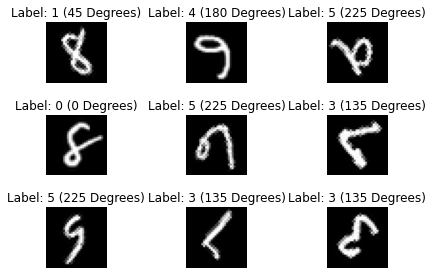

In [0]:
from fastai2.data.core import DataLoaders
dls = DataLoaders.from_dsets(train_ds, valid_ds).cuda()

# Override the show_batch function of dls to the one used in our dataset!
dls.show_batch = train_ds.show_batch

# We have 8 classes! [0, 1, 2, 3, 4, 5, 6, 7] that correspond to the [0, 45, 90, 135, 180, 225, 270, 315] degrees of rotation.
dls.c = 8

dls.show_batch()

# FastAI Vision Learner [Rotation]

In [0]:
# Create a config for our model's head!
head_config = cnn_config(lin_ftrs=[])
head_config

{'lin_ftrs': []}

> Note: We want to measure `top_2_accuracy` along with regular (top_1) accuracy, because there are hard-cases where it's understandable why our model got it wrong. For example: '0' rotated 90 or 270 degrees, or '1' rotated 0 or 180 degrees. (They can look the same!)

In [0]:
# Top_2 accuracy is a nice metric for hard-cases:
# - A zero rotated 90 or 270 degrees?
# - A one rotated 0 or 180 degrees?
# etc :P

top_2_accuracy = lambda inp, targ: top_k_accuracy(inp, targ, k=2)
top_2_accuracy

<function __main__.<lambda>>

Here, we train a model on the rotation prediction task!

In [0]:
#collapse-show
# Note to set a value for lin_ftrs, we use the defined config above.
learner = cnn_learner(dls,
                      simple_arch,
                      pretrained=False,
                      loss_func=CrossEntropyLossFlat(),
                      config=head_config,
                      metrics=[accuracy, top_2_accuracy])

learner.model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): AdaptiveConcatPool2d(
      (ap): AdaptiveAvgPool2d(output_size=1)
      (mp): AdaptiveMaxPool2d(output_size=1)
    )
    (1): Flatten(full=False)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=8, bias=False)
  )
)

In [0]:
learner.summary()

Sequential (Input shape: ['64 x 1 x 32 x 32'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 4 x 30 x 30     40         True      
________________________________________________________________
BatchNorm2d          64 x 4 x 30 x 30     8          True      
________________________________________________________________
ReLU                 64 x 4 x 30 x 30     0          False     
________________________________________________________________
Conv2d               64 x 16 x 28 x 28    592        True      
________________________________________________________________
BatchNorm2d          64 x 16 x 28 x 28    32         True      
________________________________________________________________
ReLU                 64 x 16 x 28 x 28    0          False     
________________________________________________________________
Conv2d               64 x 32 x 26 x 26    4,640      True      
___________________________________________________

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.013182567432522774)

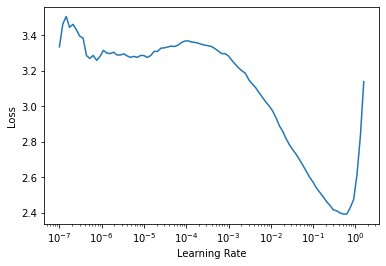

In [0]:
learner.lr_find()

In [0]:
learner.fit_one_cycle(5, lr_max=3e-2)

epoch,train_loss,valid_loss,accuracy,,time
0,0.969589,3.469174,0.371000,0.655300,01:51
1,0.861638,1.971982,0.421500,0.800700,01:52
2,0.766504,0.708317,0.672200,0.939700,01:52
3,0.674448,0.719747,0.672900,0.951400,01:52
4,0.647486,0.558277,0.756900,0.969200,01:52


> Important: We were able to achieve 79.9% top-1 accuracy, and 97.3% top-2 accuracy after just 5 epochs! Now we want to grab our `model` from our `Learner`, and save the body of it!

> Note: Our `model` has two components, the *body* and the *head*. `model` is a list of size 2, where `model[0]` is the body, and `model[1]` is the head!

In [0]:
# Access the body of our model
trained_body = learner.model[0]
trained_body

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

> Tip: To save a model in PyTorch, save it's `state_dict` function! You can use `model.load_state_dict` to re-load the weights.

In [0]:
# Make save directory if it doesn't exist
save_path = Path('rotation_cps/')
if not save_path.exists():
    save_path.mkdir()

# Save the rotation-pretraining weights of our model body
torch.save(trained_body.state_dict(), save_path/'rot_pretrained.pt')

# Original Classification Data

Now that we have pretrained our model on the rotation prediction task, we want to switch over to the original labeled data for the classification task.

> Important: We're only using 180 samples for training!

In [0]:
# Use 0.3% classification labeled data for training!
# Use 100% classification labeled data for validation!
train_ds = Custom_Dataset_MNIST('data/MNIST/processed/training.pt', pct=0.003, classification=True)
valid_ds = Custom_Dataset_MNIST('data/MNIST/processed/test.pt', pct=1.0, classification=True)
print('{0} Training Samples | {1} Validation Samples'.format(len(train_ds), len(valid_ds)))

180 Training Samples | 10000 Validation Samples


> Note: Notice the labels now correspond to the digit class!

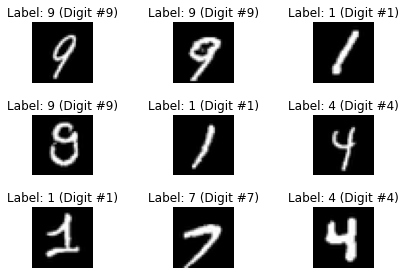

In [0]:
from fastai2.data.core import DataLoaders
dls = DataLoaders.from_dsets(train_ds, valid_ds).cuda()
dls.show_batch = train_ds.show_batch

# We have 10 classes! One for each digit label!
dls.c = 10

dls.show_batch()

# FastAI Vision Learner [Transfer-Classification]

Here we will toggle `pretrained=True` to transfer our rotation prediction features, and train on the original 180 labeled data.

In [0]:
#collapse-show
# pretrained=True will load the saved rotation pretraining weights into our model's body!
# See simple_arch() function definition for more details!
learner = cnn_learner(dls,
                      simple_arch,
                      pretrained=True,
                      loss_func=CrossEntropyLossFlat(),
                      config=head_config,
                      metrics=[accuracy])

learner.model

Loading pretrained model...
<All keys matched successfully>


Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): AdaptiveConcatPool2d(
      (ap): AdaptiveAvgPool2d(output_size=1)
      (mp): AdaptiveMaxPool2d(output_size=1)
    )
    (1): Flatten(full=False)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=10, bias=False)
  )
)

> Tip: Freezing a model's body after transferring the weights over, allows the new head to get *calibrated* with the rest of the model!

In [0]:
learner.freeze()

> Note: Looking at the model summary, we can see that the model is frozen up to the new head! Good!

In [0]:
learner.summary()

Sequential (Input shape: ['64 x 1 x 32 x 32'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 4 x 30 x 30     40         False     
________________________________________________________________
BatchNorm2d          64 x 4 x 30 x 30     8          True      
________________________________________________________________
ReLU                 64 x 4 x 30 x 30     0          False     
________________________________________________________________
Conv2d               64 x 16 x 28 x 28    592        False     
________________________________________________________________
BatchNorm2d          64 x 16 x 28 x 28    32         True      
________________________________________________________________
ReLU                 64 x 16 x 28 x 28    0          False     
________________________________________________________________
Conv2d               64 x 32 x 26 x 26    4,640      False     
___________________________________________________

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.03981071710586548)

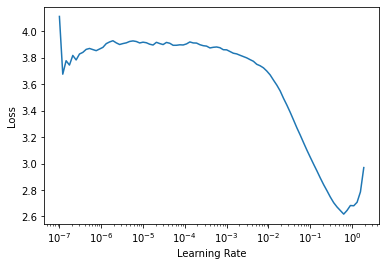

In [0]:
learner.lr_find()

In [0]:
learner.fit_one_cycle(10, lr_max=3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.792817,3.468243,0.089200,00:06
1,3.769772,3.010099,0.090200,00:06
2,3.501314,2.558095,0.149000,00:06
3,3.108911,2.312481,0.189900,00:06
4,2.747701,2.093627,0.210400,00:06
5,2.460626,1.919604,0.274100,00:06
6,2.229971,1.786942,0.367600,00:06
7,2.054399,1.679422,0.443900,00:06
8,1.910337,1.601947,0.494200,00:06
9,1.793404,1.541904,0.528000,00:06


> Tip: Unfreeze the model after calibrating the new head with the transferred body, and train a little more!

In [0]:
learner.unfreeze()

In [0]:
learner.summary()

Sequential (Input shape: ['64 x 1 x 32 x 32'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 4 x 30 x 30     40         True      
________________________________________________________________
BatchNorm2d          64 x 4 x 30 x 30     8          True      
________________________________________________________________
ReLU                 64 x 4 x 30 x 30     0          False     
________________________________________________________________
Conv2d               64 x 16 x 28 x 28    592        True      
________________________________________________________________
BatchNorm2d          64 x 16 x 28 x 28    32         True      
________________________________________________________________
ReLU                 64 x 16 x 28 x 28    0          False     
________________________________________________________________
Conv2d               64 x 32 x 26 x 26    4,640      True      
___________________________________________________

(0.025118863582611083, 3.6307804407442745e-07)

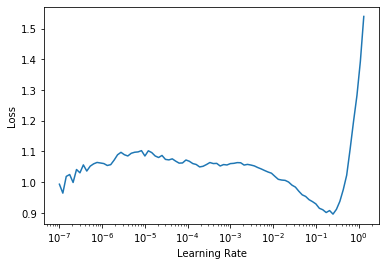

In [0]:
learner.lr_find()

In [0]:
learner.fine_tune(5, base_lr=3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.995149,1.549676,0.479500,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.982638,1.478698,0.512300,00:02
1,0.994823,1.416823,0.541200,00:02
2,1.004630,1.354943,0.569300,00:02
3,1.007987,1.292374,0.597100,00:02
4,0.976209,1.245139,0.617300,00:01


> Important: We were able to get 61.7% accuracy using transfer learning from our pretraining on the rotation prediction task!

# FastAI Vision Learner [From Sratch-Classification]

Here we train a model from scratch on the original 180 labeled data.

In [0]:
#collapse-show
# pretrained=False, Create the same model as before, but without using the rotation pretraining weights!
learner = cnn_learner(dls,
                      simple_arch,
                      pretrained=False,
                      loss_func=CrossEntropyLossFlat(),
                      config=head_config,
                      metrics=[accuracy])

learner.model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): AdaptiveConcatPool2d(
      (ap): AdaptiveAvgPool2d(output_size=1)
      (mp): AdaptiveMaxPool2d(output_size=1)
    )
    (1): Flatten(full=False)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=10, bias=False)
  )
)

In [0]:
learner.summary()

Sequential (Input shape: ['64 x 1 x 32 x 32'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 4 x 30 x 30     40         True      
________________________________________________________________
BatchNorm2d          64 x 4 x 30 x 30     8          True      
________________________________________________________________
ReLU                 64 x 4 x 30 x 30     0          False     
________________________________________________________________
Conv2d               64 x 16 x 28 x 28    592        True      
________________________________________________________________
BatchNorm2d          64 x 16 x 28 x 28    32         True      
________________________________________________________________
ReLU                 64 x 16 x 28 x 28    0          False     
________________________________________________________________
Conv2d               64 x 32 x 26 x 26    4,640      True      
___________________________________________________

(0.05248074531555176, 0.0010000000474974513)

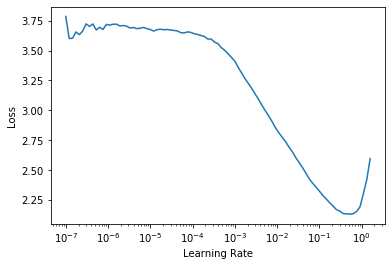

In [0]:
learner.lr_find()

In [0]:
learner.fit_one_cycle(10, lr_max=3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.452045,2.400267,0.098200,00:02
1,2.946759,2.611470,0.098200,00:02
2,2.596977,3.005997,0.098200,00:01
3,2.313555,3.860830,0.098200,00:02
4,2.055550,4.996419,0.098200,00:02
5,1.897385,5.686416,0.098200,00:02
6,1.752764,5.904824,0.098200,00:02
7,1.620871,6.086377,0.098200,00:02
8,1.537340,6.286355,0.100200,00:02
9,1.469650,6.423689,0.130200,00:02


> Important: We were able to only get 13% accuracy with training from scratch

# Conclusion

> Important: Using self-supervision can help learn features that can transfer to a down-stream task, such as classification! In this example, we used rotation predication as our pretext task for feature representation learning. Pretraining our model on rotation prediction prior to training for classification allowed us to achieve 61.7% accuracy, on just 0.3% of the labeled data (180 samples)! Training from scratch with the same amount of data yields an accuracy of 13%. The motivation for using self-supervised learning is the ability to train models with decent accuracy without the need of much labeled data!

> Note: Be sure to try other self-supervised learning methods (or perhaps find your own!) and compete on the [ImageWang Leadboard](https://github.com/fastai/imagenette#image%E7%BD%91-leaderboard)! How will model size, data difficultly, and dataset size (number of samples) affect self-supervised learning?